In [78]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
#import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [79]:
#Making the environment
env = gym.make("CartPole-v1")

## Initialize variables

In [80]:
#Defining Hypermeters
#LEARNING_RATE = 0.1
LEARNING_RATE = 0.2

DISCOUNT = 0.999 #instead of 0.95
EPISODES = 60000
total = 0
total_reward = 0

#0.25, 0.25, 0.01, 0.1
# Define observation and window size
Observation = [40, 40, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.05, 0.5])

epsilon = 0.99
epsilon_decay = (epsilon -0.1)/12500
epsilon_min = 0.1
epsilon_max = 0.95

prev_mean = 0
obs = env.reset()

rewardArr = []

new_env = env.step(0)[0]
print(new_env)
print(round(new_env[2], 2))

[ 0.00784012 -0.15168767  0.01494143  0.26440138]
0.01


## Create Q table

In [81]:
#Creating the q table
q_table = np.zeros((Observation + [env.action_space.n]))
q_table.shape

(40, 40, 50, 50, 2)

## Getting discrete state

In [82]:
#defining the discrete state
def get_discrete_state(state):
    
    #Given a state, round to the nearest 0.25
    #divide by the window size to find which bucket it belongs to
    #discrete_state =np.array([np.round(state[0]*4)/4, np.round(state[1] *4) /4, np.round(state[2], 1) ,np.round(state[3], 1)])
    #discrete_state =np.array([np.round(state[0]*2)/2, np.round(state[1] *2) /2, np.round(state[2]* 2)/2 ,np.round(state[3]* 2)/2])
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])
    #discrete_state = (discrete_state/np_array_win_size)
    #print(discrete_state)
    return tuple(discrete_state.astype(int))


print(get_discrete_state([4, -2, 0.418, 0.63751878]))

(31, 2, 9, 11)


## Running

In [83]:
   for episode in range(EPISODES):
        discrete_state = get_discrete_state(env.reset()[0])
        done = False
        episode_reward = 0
        episode_length = 0

        # update every 2000 episodes
        if episode % 2000 == 0:
            print("Episode: " + str(episode))

        while not done:

            # always get max for now
            if np.random.random() > epsilon:
                action = np.argmax(q_table[discrete_state])
            else:
                action = np.random.randint(0, env.action_space.n)

            new_env = env.step(action)
            new_state = new_env[0]
            reward = new_env[1]
            done = new_env[2]
            episode_reward += reward
            episode_length += 1

            new_discrete_state = get_discrete_state(new_state)
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]

            # Reward shaping
            if done:
                if episode_length >= 195:
                    reward = 1
                else:
                    reward = -1
            else:
                reward = 0.1

            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

            discrete_state = new_discrete_state

            # check termination conditions
            #if abs(new_state[0]) > 2.4 or abs(new_state[2]) > np.radians(12) or episode_length > 500:
                 #done = True

        total_reward += episode_reward
        rewardArr.append(episode_reward)
        if epsilon > 0.08:
            epsilon -= epsilon_decay
        if episode % 1000 == 0:
            print("Epsilon: " + str(epsilon))
            mean_reward = total_reward / 1000
            print("Mean Reward: " + str(mean_reward))

            prev_mean = mean_reward
            total_reward = 0


env.close()


Episode: 0
Epsilon: 0.9899287999999999
Mean Reward: 0.024
Epsilon: 0.9187287999999509
Mean Reward: 24.219
Episode: 2000
Epsilon: 0.8475287999999019
Mean Reward: 26.411
Epsilon: 0.7763287999998529
Mean Reward: 33.214
Episode: 4000
Epsilon: 0.7051287999998039
Mean Reward: 39.925
Epsilon: 0.6339287999997549
Mean Reward: 46.941
Episode: 6000
Epsilon: 0.5627287999997059
Mean Reward: 55.986
Epsilon: 0.49152879999966353
Mean Reward: 68.842
Episode: 8000
Epsilon: 0.42032879999967004
Mean Reward: 81.857
Epsilon: 0.34912879999967655
Mean Reward: 91.808
Episode: 10000
Epsilon: 0.27792879999968306
Mean Reward: 108.978
Epsilon: 0.20672879999968957
Mean Reward: 117.365
Episode: 12000
Epsilon: 0.13552879999969608
Mean Reward: 145.188
Epsilon: 0.07999279999970116
Mean Reward: 146.999
Episode: 14000
Epsilon: 0.07999279999970116
Mean Reward: 166.318
Epsilon: 0.07999279999970116
Mean Reward: 170.968
Episode: 16000
Epsilon: 0.07999279999970116
Mean Reward: 173.08
Epsilon: 0.07999279999970116
Mean Reward: 

Average cumulative reward:255.33401666666666
Is my agent good enough? True


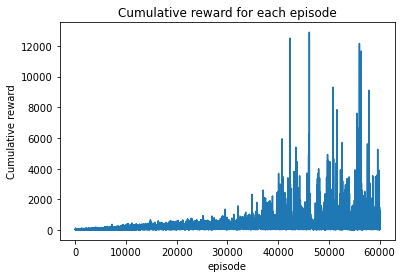

In [84]:
plt.plot(rewardArr)
print("Average cumulative reward:" + str(np.mean(rewardArr)))
print("Is my agent good enough? " + str(np.mean(rewardArr) > 195))

plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')

plt.show()

In [85]:
episode_reward = 0

env = RecordVideo(gym.make("CartPole-v1", render_mode="human"),"./video")
observation = env.reset()
discrete_state = get_discrete_state(observation[0])

done = False
while not done:
    env.render()
    action = np.argmax(q_table[discrete_state])
    new_env = env.step(action)
    new_state = new_env[0]
    reward = new_env[1]
    done = new_env[2]
    episode_reward += reward
    
    new_discrete_state = get_discrete_state(new_state)
    discrete_state = new_discrete_state

    if done:
        observation = env.reset()
        discrete_state = get_discrete_state(observation[0])

env.close()
show_video()
print(episode_reward)

DependencyNotInstalled: pygame is not installed, run `pip install gym[classic_control]`